In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data
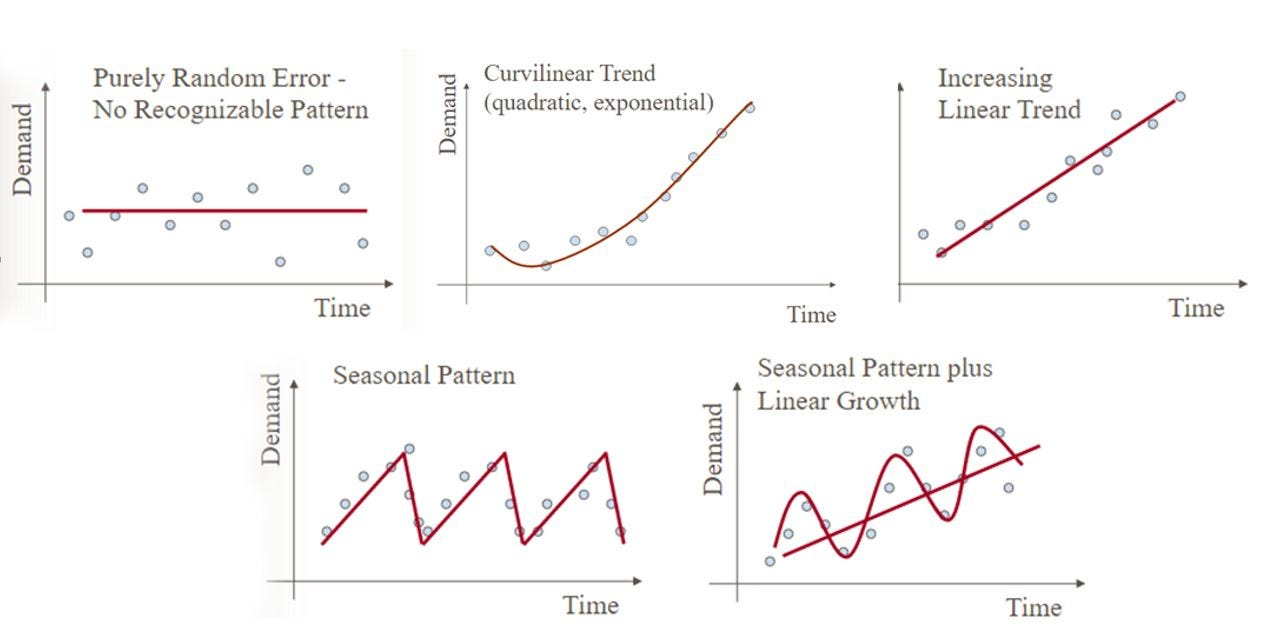

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df.set_index('Datetime', inplace=True)

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


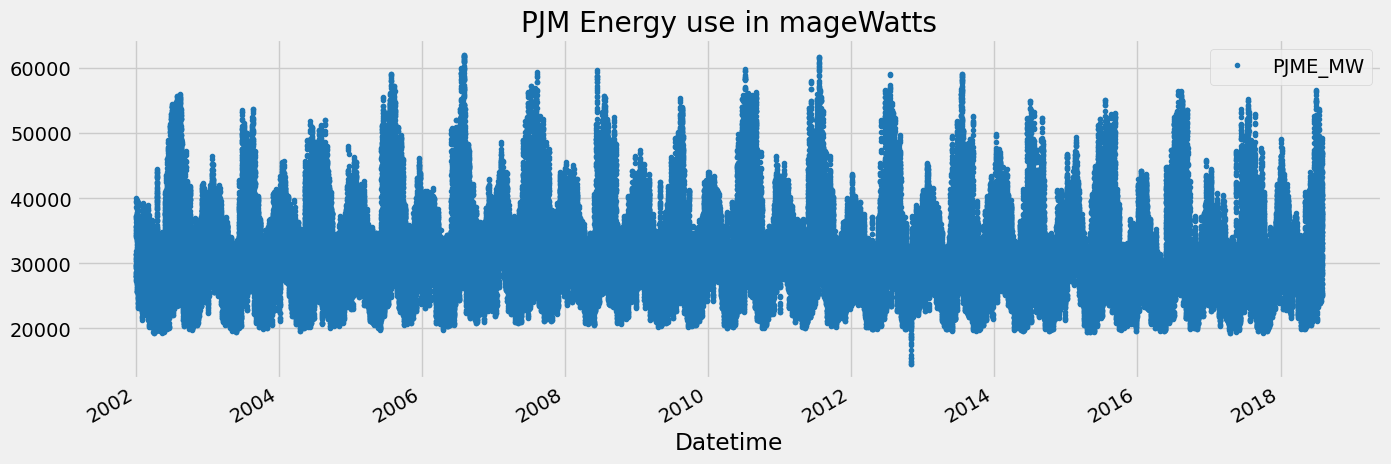

In [5]:
df.plot(style='.', 
        figsize=(15,5),
        color = color_pal[0], 
        title='PJM Energy use in mageWatts')
plt.show()

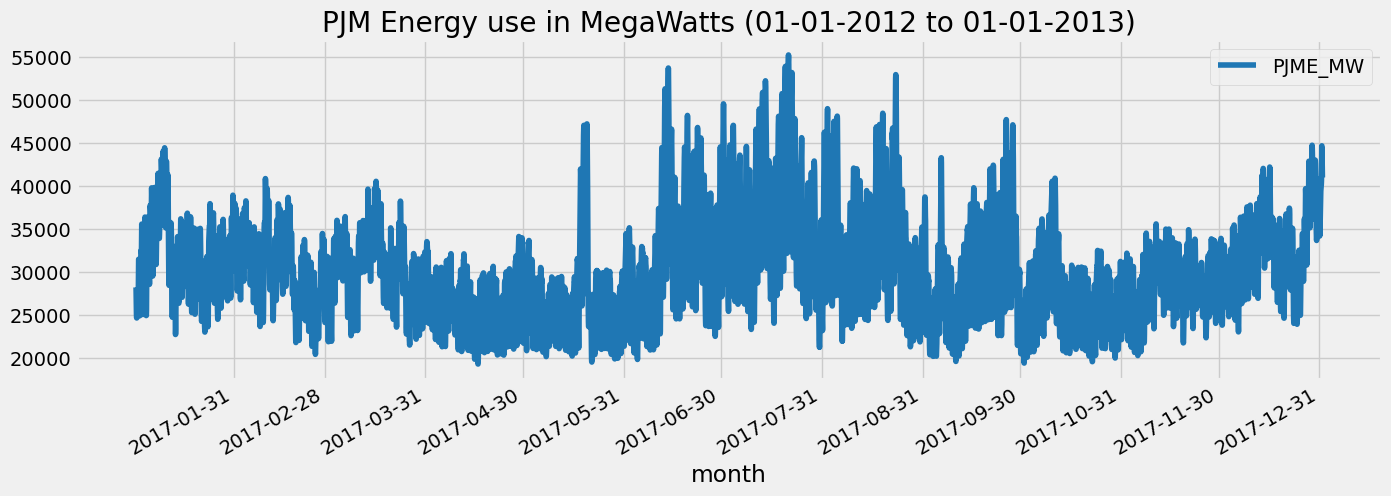

In [6]:
# plot one year intercal
df_2012_2013 = df.loc['2017-01-01':'2017-12-31']


# Plot the filtered data
df_2012_2013.plot(style='-', 
                  figsize=(15,5),
                  color = color_pal[0], 
                  title='PJM Energy use in MegaWatts (01-01-2012 to 01-01-2013)')
# x-axis manual label
plt.xlabel('month')
# x ticks for each month
plt.xticks(pd.date_range('2017-01-01','2018-01-01', freq='M'))
plt.show()

# Train / Test Split

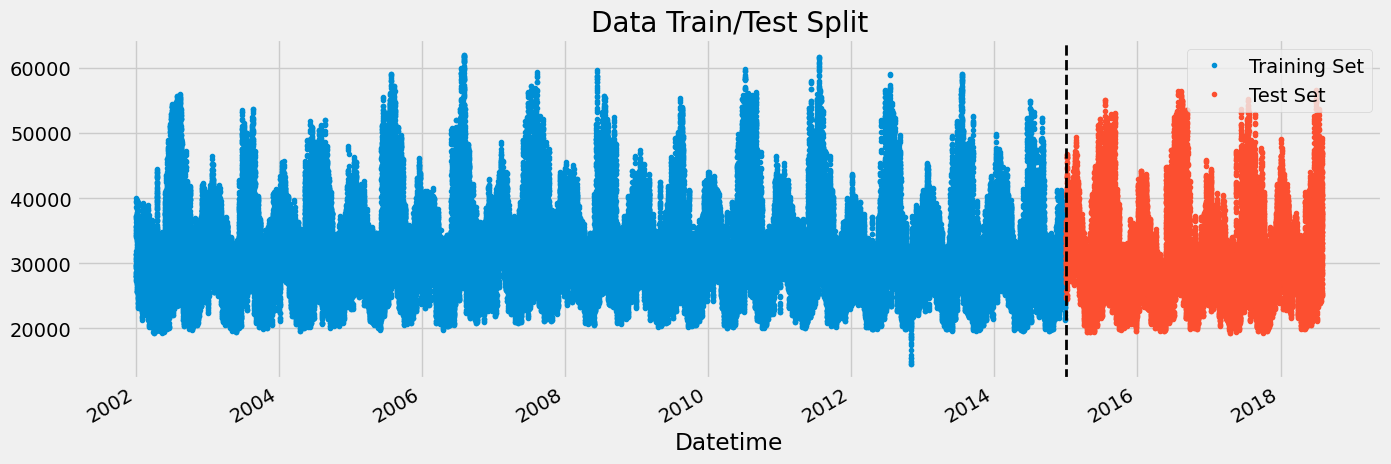

In [29]:
train = df[df.index < '01-01-2015']
test = df[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label = 'Training Set', style='.', title='Data Train/Test Split')
test.plot(ax=ax,label = 'Test Set', style='.')
ax.axvline('01-01-2015', color='black', linestyle='--', lw=2)
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'PJM Energy use in mageWatts'}, xlabel='Datetime'>

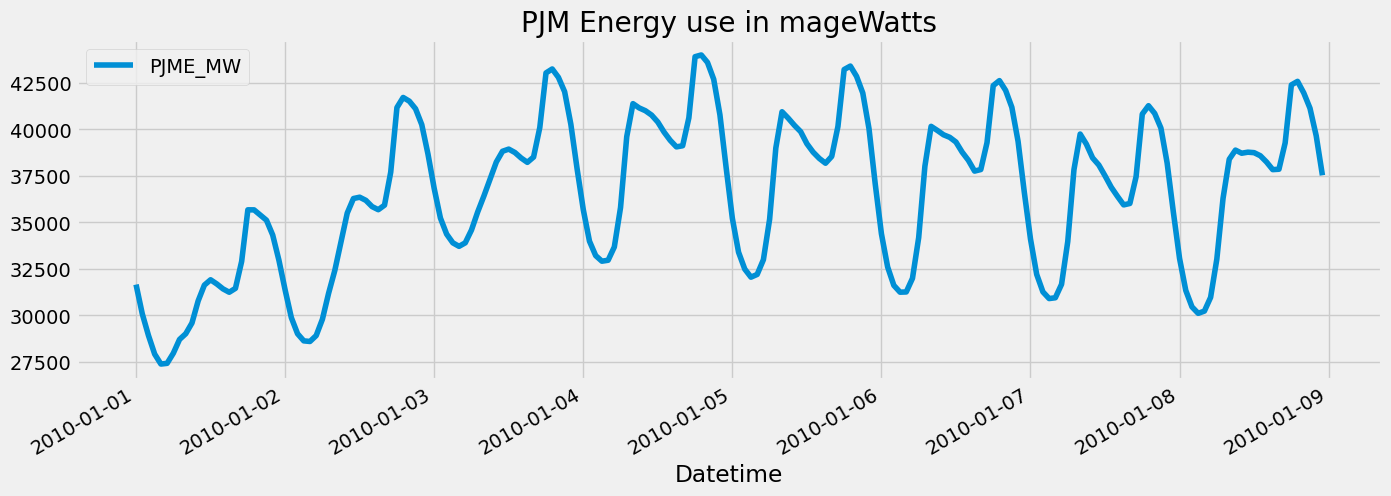

In [ ]:
df['2010-01-01':'2010-01-08'].plot(style='-', 
        figsize=(15,5),
        color = color_pal[0], 
        title='PJM Energy use in mageWatts')

# Feature Creation

In [ ]:
# Feature Creation
def create_features(df): 
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df = create_features(df)

In [ ]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


# Visualize our Feature / Target Relationship

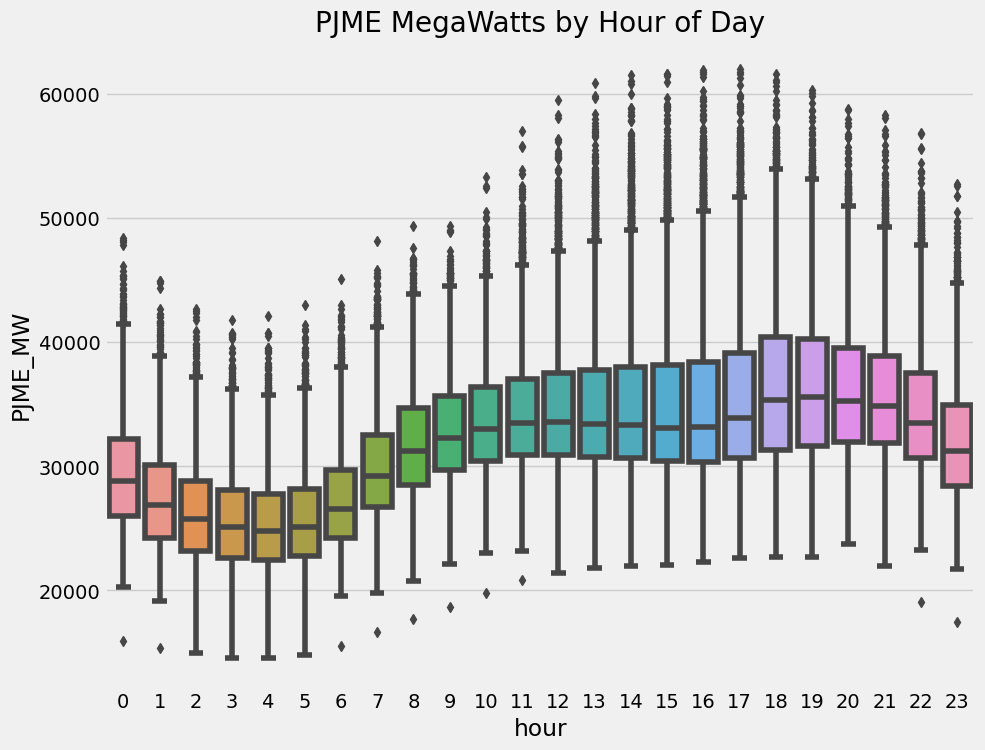

In [ ]:
# Visualize our Feature / Target Relationship
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set(title='PJME MegaWatts by Hour of Day')
plt.show()

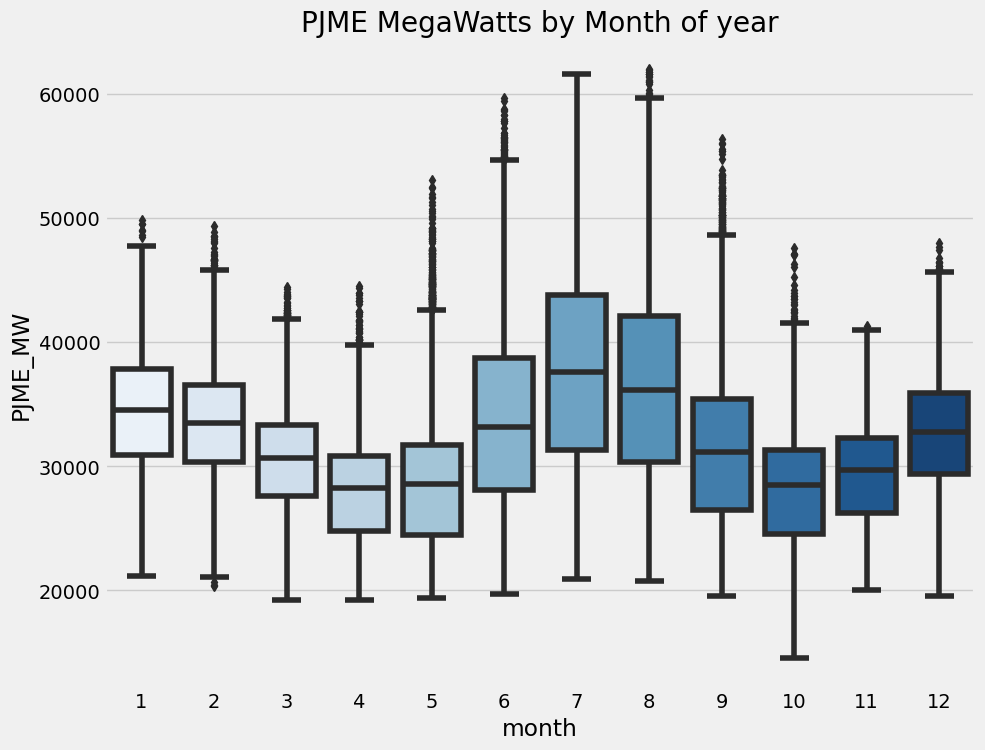

In [ ]:
# Visualize our Feature / Target Relationship
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set(title='PJME MegaWatts by Month of year')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

# Create out Model

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Create out Model
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

[0]	validation_0-rmse:6009.63254	validation_1-rmse:6111.06123


[20]	validation_0-rmse:3188.64081	validation_1-rmse:3833.63980
[40]	validation_0-rmse:2823.46562	validation_1-rmse:3758.40706
[60]	validation_0-rmse:2640.17941	validation_1-rmse:3815.86192
[80]	validation_0-rmse:2480.18347	validation_1-rmse:3872.25869
[81]	validation_0-rmse:2468.56996	validation_1-rmse:3881.55728


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = X_train.columns,
             columns = ['Importance'])

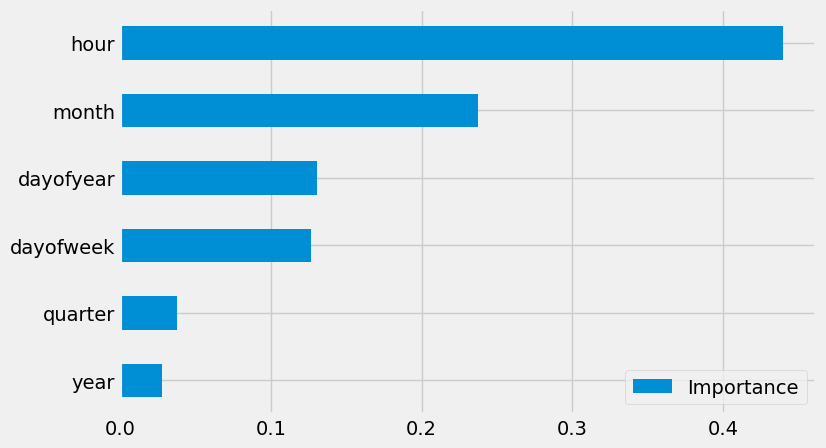

In [ ]:
fi.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(8,5))
plt.show()

In [ ]:
# Fortcast On Test Set
test['prediction'] = reg.predict(X_test)

In [ ]:
dff = df.merge(test[['PJME_MW', 'prediction']], how='left', left_index=True, right_index=True).copy()

In [ ]:
dff

,PJME_MW_x,hour,dayofweek,quarter,month,year,dayofyear,PJME_MW_y,prediction
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,44057.0,43176.148438
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,43256.0,42718.625000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,41552.0,40270.351562


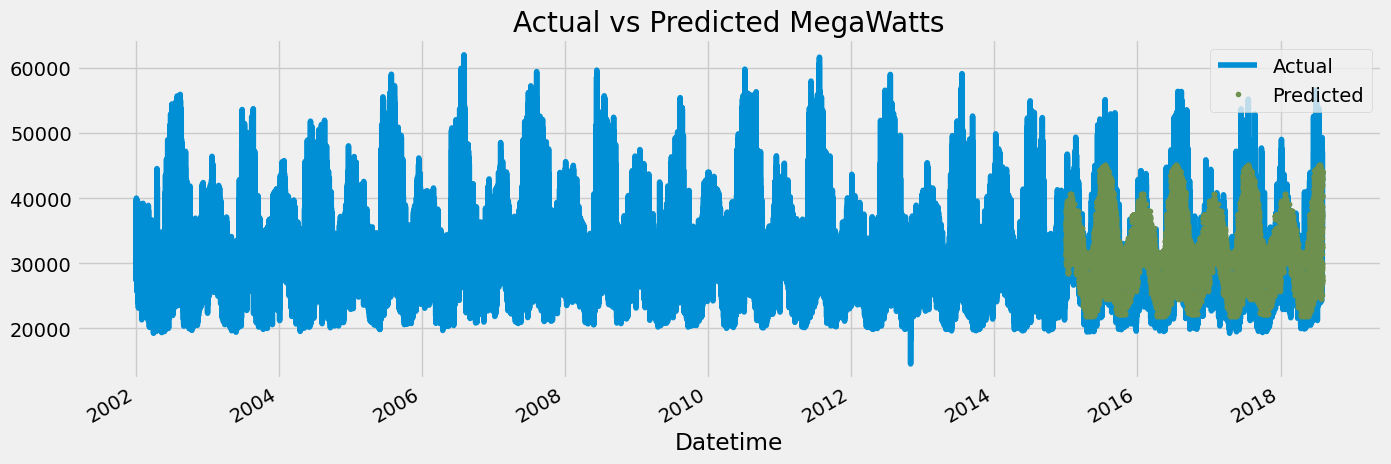

In [ ]:
ax = dff[['PJME_MW_x']].plot(figsize=(15,5), color=color_pal[0])
dff['prediction'].plot(ax=ax, style='.', color=color_pal[3])
plt.legend(['Actual', 'Predicted'])
ax.set(title='Actual vs Predicted MegaWatts')
plt.show()

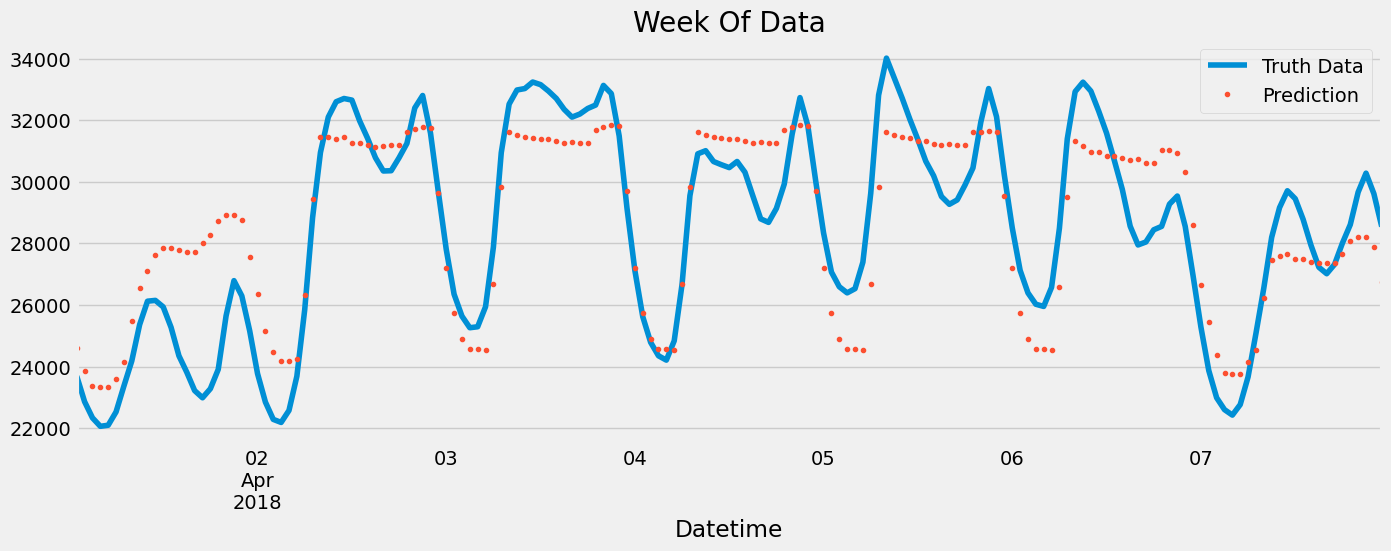

In [ ]:
ax = dff.loc[(dff.index > '04-01-2018') & (dff.index < '04-08-2018')]['PJME_MW_x'] \
    .plot(figsize=(15, 5), title='Week Of Data')
dff.loc[(dff.index > '04-01-2018') & (dff.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE: {score:0.2f}')

RMSE: 3742.56


# Calculate Error

In [ ]:
# Calculate error
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])

In [ ]:
test['date'] = test.index.date

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13399.285807
2016-08-14    13241.411133
2016-09-10    11428.654134
2016-09-09    11206.211426
2016-08-12    10655.733805
2018-01-06    10441.521240
2015-02-20    10143.624023
2018-01-07     9729.648112
2015-02-16     9480.011963
2017-05-19     9301.219645
Name: error, dtype: float64

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=False).tail(10)

date
2016-12-08    536.866374
2017-10-24    536.163900
2017-05-02    525.055339
2016-12-12    513.322591
2016-01-12    506.175700
2017-04-01    504.791992
2016-10-27    501.721029
2016-04-04    473.363770
2018-02-06    473.306966
2016-12-30    264.619954
Name: error, dtype: float64

In [ ]:
# make robust corss validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]

# Create out Model
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.1)
reg.fit(X_train
        , y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

TRAIN: [    0     1     2 ... 18988 18989 18990] TEST: [18991 18992 18993 ... 37975 37976 37977]
TRAIN: [    0     1     2 ... 37975 37976 37977] TEST: [37978 37979 37980 ... 56962 56963 56964]
TRAIN: [    0     1     2 ... 56962 56963 56964] TEST: [56965 56966 56967 ... 75949 75950 75951]
TRAIN: [    0     1     2 ... 75949 75950 75951] TEST: [75952 75953 75954 ... 94936 94937 94938]
TRAIN: [    0     1     2 ... 94936 94937 94938] TEST: [ 94939  94940  94941 ... 113923 113924 113925]
[0]	validation_0-rmse:6009.63254	validation_1-rmse:6111.06123


[20]	validation_0-rmse:3188.64081	validation_1-rmse:3833.63980
[40]	validation_0-rmse:2823.46562	validation_1-rmse:3758.40706
[60]	validation_0-rmse:2640.17941	validation_1-rmse:3815.86192
[80]	validation_0-rmse:2480.18347	validation_1-rmse:3872.25869
[82]	validation_0-rmse:2460.48638	validation_1-rmse:3888.02891


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

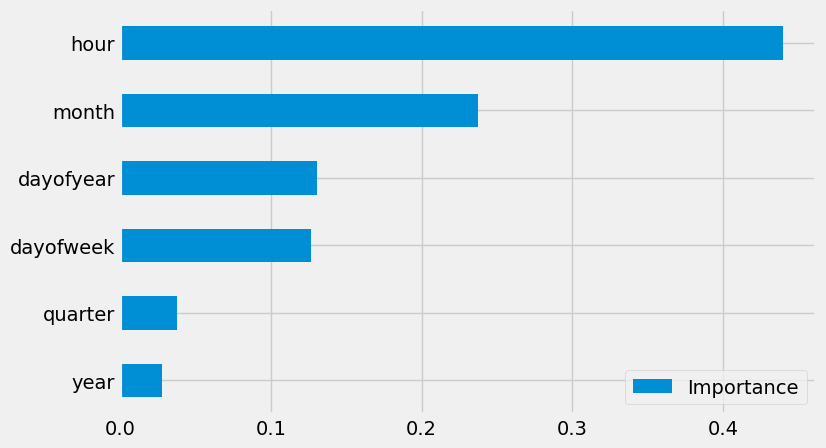

In [ ]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = X_train.columns,
             columns = ['Importance'])

fi.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(8,5))
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 2923.321617503081
Mean Squared Error: 14006777.07270574
Root Mean Squared Error: 3742.5629016364896
